In [1]:
import pandas as pd
import numpy as np
from heavylight import Model
import heavytables
import seaborn as sns

# Table Examples

## Loading a CMI table (2 integer based keys)

In [2]:
# load the mortality table - in this case a CMI like table with fake mortality rates.
qx_table = heavytables.Table.read_csv('csv_tables/fake_tmnl16.csv')

# view the table - we can view the input dataframe used to populate it
qx_table.df

,age|int,dur|int,q_x|float
0,18,0,0.000005
6,19,0,0.000006
12,20,0,0.000006
18,21,0,0.000007
24,22,0,0.000008
...,...,...,...
581,114,5,0.201897
587,115,5,0.223130
593,116,5,0.246597
599,117,5,0.272532


In [3]:
# we can do individual value lookups:
qx_table[115, 5]

0.22313016014843

In [4]:
# we can pull multiple values as arrays
ages = np.array([18, 19, 20])
durs = np.array([0, 5, 3])
qx_table[ages, durs]

array([0.000005, 0.000015, 0.000011])

In [5]:
# as an alternative to [] indexing, you can use .get(keys...)
qx_table.get(ages, durs)

array([0.000005, 0.000015, 0.000011])

In [6]:
# we can combine these, so either a numpy.ndarray can be supplied, or a python integer
qx_table[np.arange(114, 118), 5]

array([0.201897, 0.223130, 0.246597, 0.272532])

In [7]:
# we get an error if we go out of bounds
try:
    qx_table[2512, 55]
except Exception as err:
    print(repr(err))

IndexError('index 8049 is out of bounds for axis 0 with size 606')


In [8]:
# as a test, we can check that the table completes itself
df_mort = qx_table.df.sample(n=1_000_000, replace=True) # sample 1m points from the dataframe
df_mort

,age|int,dur|int,q_x|float
247,59,1,0.000371
489,99,3,0.030197
16,20,4,0.000014
115,37,1,0.000041
382,81,4,0.006097
...,...,...,...
24,22,0,0.000008
504,102,0,0.022371
299,67,5,0.001836
144,42,0,0.000055


In [9]:
# pandas Series (columns) can be parsed as numpy arrays (albeit a little more slowly than grabbing .values)
df_mort['table_val'] = qx_table[df_mort['age|int'], df_mort['dur|int']]
df_mort.tail(5)

,age|int,dur|int,q_x|float,table_val
24,22,0,0.000008,0.000008
504,102,0,0.022371,0.022371
299,67,5,0.001836,0.001836
144,42,0,0.000055,0.000055
157,44,1,0.000083,0.000083


In [10]:
# check the values are the same
np.allclose(df_mort['q_x|float'], df_mort['table_val'])

True

In [11]:
%timeit qx_table[df_mort['age|int'].values, df_mort['dur|int'].values]

3.89 ms ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
# there is a little bit more overhead if accessing the Series rather than the array (as it needs converted)
%timeit qx_table[df_mort['age|int'], df_mort['dur|int']]

5.65 ms ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This overhead could be reduced by checking if the input data is `pandas.Series`, and then grabbing `.values`. 

## Loading a Table with Various Keys

In [13]:
#sib = string int band keys
tab_sib = heavytables.Table.read_csv('csv_tables/table_str_int_band.csv')

In [14]:
tab_sib.df

,product|str,year|int,fund_to|band,value|float
0,ABC,2023,10000,2.76
7,DEFG,2023,10000,3.68
14,IJKLM,2023,10000,4.61
21,ABC,2024,10000,5.53
28,DEFG,2024,10000,7.37
...,...,...,...,...
34,DEFG,2024,99999999999,20.26
41,IJKLM,2024,99999999999,25.33
48,ABC,2025,99999999999,22.80
55,DEFG,2025,99999999999,30.39


This table has a string column, year column and band column.

The band column looks up values up to and including that band value, e.g. 5000 -> 10000

In [15]:
tab_sib['ABC', 2023, 5000]

2.76

In [16]:
# again we can used vectorised
products = np.array(['DEFG', 'ABC', 'DEFG'])
years = np.array([2023, 2023, 2024])
funds = np.array([5000, 15000, 25000])
tab_sib[products, years, funds]

array([3.680000, 3.040000, 8.100000])

In [17]:
# we can mix arrays and scalars
tab_sib['ABC', 2023, funds]

array([2.760000, 3.040000, 3.040000])

Text(0.5, 1.0, 'Plot of Fund Value against Table Output')

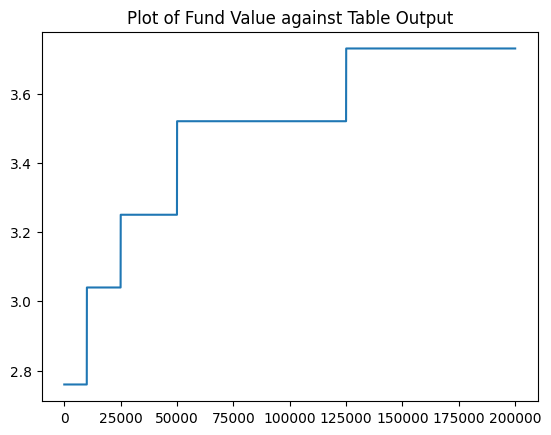

In [18]:
# plotting these
funds_range = np.linspace(0, 200_000, 10_000)
tab_sib_vals = tab_sib['ABC', 2023, funds_range]
ax = sns.lineplot(x=funds_range, y=tab_sib_vals)
ax.set_title('Plot of Fund Value against Table Output')

In [19]:
rng = np.random.default_rng(seed=42)

In [20]:
# performance of this table

tab_sib_test = tab_sib.df.sample(1_000_000, replace=True).iloc[:,[0,1]]
tab_sib_test['fund_value'] = rng.gamma(4, 20_000, 1_000_000)
tab_sib_test

,product|str,year|int,fund_value
40,IJKLM,2024,85633.070815
15,IJKLM,2023,105991.431881
26,ABC,2024,78339.010719
9,DEFG,2023,72691.778013
21,ABC,2024,112430.396475
...,...,...,...
56,IJKLM,2025,63996.696706
16,IJKLM,2023,156440.567757
42,ABC,2025,89220.697628
40,IJKLM,2024,61364.701263


In [21]:
tab_sib[
    tab_sib_test.iloc[:,0].values,
    tab_sib_test.iloc[:,1].values,
    tab_sib_test.iloc[:,2].values
]

array([11.740000, 5.870000, 7.040000, ..., 10.560000, 11.740000, 6.210000])

In [22]:
%timeit tab_sib[ \
    tab_sib_test.iloc[:,0].values,\
    tab_sib_test.iloc[:,1].values,\
    tab_sib_test.iloc[:,2].values\
]

81.4 ms ± 937 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Testing a table with bounded columns

Bounded columns (suffixed `|int_bound` in the header) use the highest/lowest value where the key is outside the bound.

This is particularly useful for simplifying code where using mortality tables, e.g. different versions of mortality tables have different select periods, but may be intermingled.

In [25]:
qx_b = heavytables.Table.read_csv('csv_tables/fake_tmnl16_bound.csv')

In [28]:
# we can check that this is bounded, by viewing the mappers - second column is now BoundIntLookup
qx_b.mappers

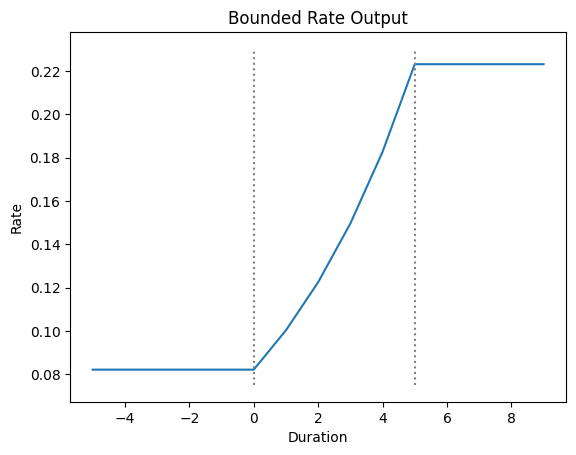

In [46]:
durs = np.arange(-5, 10)
ax = sns.lineplot(x=durs, y=qx_b[115, durs])
ax_low, ax_high = ax.get_ylim()
ax.plot([5, 5], [ax_low, ax_high], linestyle='dotted', color='grey')
ax.plot([0, 0], [ax_low, ax_high], linestyle='dotted', color='grey')
ax.set_xlabel('Duration')
ax.set_ylabel('Rate')
ax.set_title('Bounded Rate Output');